# 1. Convolution Neural Network
A Convolutional Neural Network (CNN) is a type of deep learning model designed to process data with a grid-like topology, such as images. It is widely used in image classification, object detection, and video analysis.

## Component

### Convolution Layer
Applies filters (kernels) to the input to extract local features like edges, corners, or textures.
```Py
torch.nn.Conv2d(
    in_channels,
    out_channels,
    kernel_size,
    stride=1,
    padding=0,
    ...
)
```
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

### Pooling Layer
Reduces the spatial size of the feature maps to lower computational cost and retain important information.

ex) Max Pooling, Average Pooling

```Py
torch.nn.MaxPool2d(
    kernel_size,
    stride=None,
    padding=0
    ...
)
```
https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

### Relu Activation Function
Introduces non-linearity by setting negative values to zero and keeping positive values.
```Py
torch.nn.functional.relu(
    input
)
```
https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html

### Dropout
Dropout is a regularization technique used to prevent overfitting in neural networks.
```Py
torch.nn.Dropout(
    p # dropout percent
)
```
https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html


### Fully Connected Layer
Typically at the end of the network, responsible for making final decisions (like classification) based on the extracted features.

```Py
torch.nn.Linear(
    in_features,
    out_features,
    ...
)
```
https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

# 2. Import Libaray

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 3. MNIST data
The MNIST (Mixed National Institute of Standards and Technology) dataset
is a collection of handwritten digit images, ranging from 0 to 9.

## Detail
Image Size: 28 × 28 pixels, grayscale

Data Split: Training images: 60,000, Test images: 10,000

Number of Classes: 10 (digits from 0 to 9)

<img src="https://storage.googleapis.com/tfds-data/visualization/fig/mnist-3.0.1.png" width="500"/>

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # [0,1]
    transforms.Normalize((0.5,), (0.5,))  # [-1,1]
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# 4. Model Implement
<img src="./그림1.jpg" width="500"/>
<img src="./그림2.jpg" width="500"/>


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * 5 * 5, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [6]:
for epoch in range(15):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

Epoch 1, Loss: 375.0199
Epoch 2, Loss: 132.3953
Epoch 3, Loss: 92.6791
Epoch 4, Loss: 73.6675
Epoch 5, Loss: 63.5988
Epoch 6, Loss: 56.1806
Epoch 7, Loss: 51.5981
Epoch 8, Loss: 47.0752
Epoch 9, Loss: 44.2062
Epoch 10, Loss: 42.0818
Epoch 11, Loss: 40.2117
Epoch 12, Loss: 38.0956
Epoch 13, Loss: 36.5752
Epoch 14, Loss: 35.8459
Epoch 15, Loss: 34.3372


In [7]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9847


In [8]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
           Dropout-2           [-1, 32, 26, 26]               0
         MaxPool2d-3           [-1, 32, 13, 13]               0
            Conv2d-4           [-1, 64, 11, 11]          18,496
           Dropout-5           [-1, 64, 11, 11]               0
         MaxPool2d-6             [-1, 64, 5, 5]               0
           Flatten-7                 [-1, 1600]               0
            Linear-8                   [-1, 10]          16,010
Total params: 34,826
Trainable params: 34,826
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.51
Params size (MB): 0.13
Estimated Total Size (MB): 0.65
----------------------------------------------------------------


✅ correct


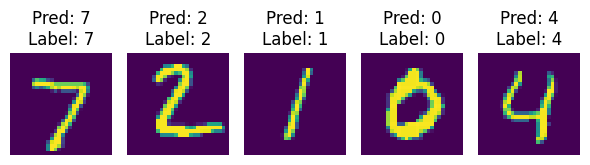

❌ wrong


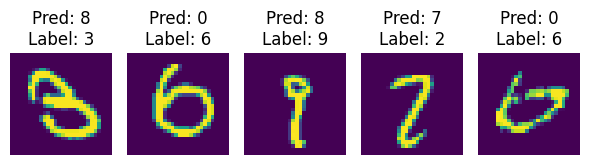

In [9]:
import matplotlib.pyplot as plt
import numpy as np

classes = [str(i) for i in range(10)]

def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

def show_predictions(model, dataloader, device):
    model.eval()
    correct_samples = []
    incorrect_samples = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for img, pred, label in zip(images, predicted, labels):
                if len(correct_samples) < 5 and pred == label:
                    correct_samples.append((img.cpu(), pred.item(), label.item()))
                elif len(incorrect_samples) < 5 and pred != label:
                    incorrect_samples.append((img.cpu(), pred.item(), label.item()))
                
                if len(correct_samples) >= 5 and len(incorrect_samples) >= 5:
                    break
            if len(correct_samples) >= 5 and len(incorrect_samples) >= 5:
                break

    print("✅ correct")
    plt.figure(figsize=(6, 3))
    for i, (img, pred, label) in enumerate(correct_samples):
        plt.subplot(1, 5, i+1)
        imshow(img, f"Pred: {classes[pred]}\nLabel: {classes[label]}")
    plt.tight_layout()
    plt.show()

    print("❌ wrong")
    plt.figure(figsize=(6, 3))
    for i, (img, pred, label) in enumerate(incorrect_samples):
        plt.subplot(1, 5, i+1)
        imshow(img, f"Pred: {classes[pred]}\nLabel: {classes[label]}")
    plt.tight_layout()
    plt.show()

show_predictions(model, test_loader, device)